# COMPSCI589 Homework 3
##### Chang Liu, 4.10.2022

## Programming: Random Forest Algorithm

In [32]:
from random_forest import *
import matplotlib.pyplot as plt

## The Wine Dataset 


In [33]:
# load wine data 
wine_data, wine_attribute = load_data("datasets/hw3_wine.csv", csv_delimiter='\t')
wine_attribute_type = ["class","numerical","numerical","numerical","numerical","numerical","numerical","numerical","numerical","numerical","numerical","numerical","numerical","numerical"]
wine_attribute_options = get_possible_options(wine_data, wine_attribute, wine_attribute_type)
wine_tag_col = 0
print("classes: " , wine_attribute_options[wine_tag_col])

classes:  [1.0, 2.0, 3.0]


In [34]:
# evaluate wine data using random forest
ntree_itr = [1, 5, 10, 20, 30, 40, 50]
reports_wine = []
print("accuracy, precision, recall, f1")
for cur_n in ntree_itr:
    report = dispatch_k_fold(wine_data, 
        wine_attribute, 
        wine_attribute_type, 
        wine_attribute_options, 
        wine_tag_col, 
        minimal_size_for_split=0.,
        minimal_gain=0.,
        maximal_depth=10000,
        algo="entropy",  
        random_state=42, 
        k_fold=10,
        n_trees=cur_n,
        binary_class=False, 
        bootstrap_percentage=0.9
    )
    reports_wine.append(report)
    print("n =", cur_n, report)
    

accuracy, precision, recall, f1
n = 1 [0.88903724 0.90373016 0.88801587 0.8843267 ]
n = 5 [0.93885449 0.95205026 0.93873016 0.93910584]
n = 10 [0.92862057 0.93691799 0.92876984 0.92663198]
n = 20 [0.97222222 0.9765873  0.97349206 0.97254338]
n = 30 [0.96633987 0.96992063 0.96873016 0.96627558]
n = 40 [0.97156863 0.97349206 0.97619048 0.97189847]
n = 50 [0.97189542 0.9740873  0.97539683 0.9722015 ]


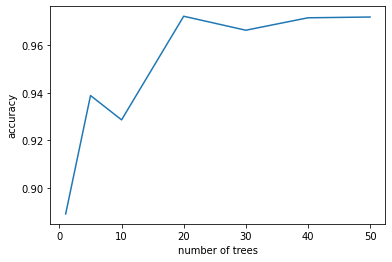

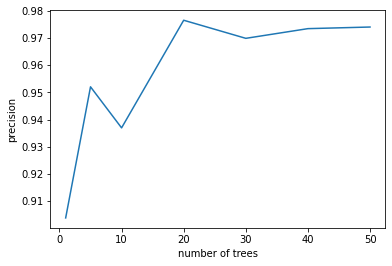

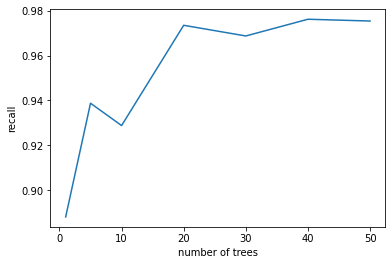

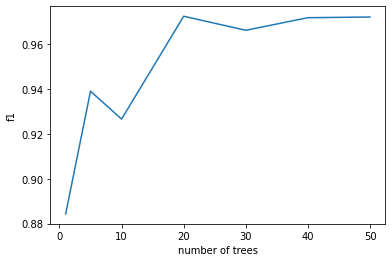

In [35]:
# plot accuracy 
plt.plot(ntree_itr, [r[0] for r in reports_wine], label="accuracy")
plt.xlabel("number of trees")
plt.ylabel("accuracy")
plt.show()
# plot precision 
plt.plot(ntree_itr, [r[1] for r in reports_wine], label="precision")
plt.xlabel("number of trees")
plt.ylabel("precision")
plt.show()
# plot recall 
plt.plot(ntree_itr, [r[2] for r in reports_wine], label="recall")
plt.xlabel("number of trees")
plt.ylabel("recall")
plt.show()
# plot f1
plt.plot(ntree_itr, [r[3] for r in reports_wine], label="f1")
plt.xlabel("number of trees")
plt.ylabel("f1")
plt.show()

### Discussion

I would choose ntree=20, since it maximize all evaluation metrics.  
For this dataset, accuracy, precision, recall, and f1 are almost equally sensitive to the change of n.  
Beyond n>20, adding more trees does not increase the performance.  


## The 1984 United States Congressional Voting Dataset

In [36]:
# load house data
house_data, house_attribute = load_data("datasets/hw3_house_votes_84.csv")
house_attribute_type = ["categorical","categorical","categorical","categorical","categorical","categorical","categorical","categorical","categorical","categorical","categorical","categorical","categorical","categorical","categorical","categorical","class"]
house_attribute_options = get_possible_options(house_data, house_attribute, house_attribute_type)
house_tag_col = -1
print("classes: " , house_attribute_options[house_tag_col])

classes:  [0.0, 1.0]


In [37]:
# evaluate house data using random forest
reports_house = []
print("accuracy, precision, recall, f1")
for cur_n in ntree_itr:
    report = dispatch_k_fold(house_data, 
        house_attribute, 
        house_attribute_type, 
        house_attribute_options, 
        house_tag_col, 
        minimal_size_for_split=0.,
        minimal_gain=0.,
        maximal_depth=10000,
        algo="entropy",  
        random_state=42, 
        k_fold=10,
        n_trees=10,
        binary_class=False, 
        bootstrap_percentage=0.9
    )
    reports_house.append(report)
    print("n =", cur_n, report)
    

accuracy, precision, recall, f1
n = 1 [0.94686399 0.94220754 0.94898714 0.94457297]
n = 5 [0.94897564 0.94642959 0.95069654 0.94693867]
n = 10 [0.96060858 0.9588826  0.9613714  0.9586872 ]
n = 20 [0.95352361 0.9518123  0.95349474 0.95114197]
n = 30 [0.95817225 0.95521948 0.9591519  0.95618378]
n = 40 [0.94897564 0.94704138 0.94967844 0.94672533]
n = 50 [0.96060858 0.95970529 0.96144262 0.95866677]


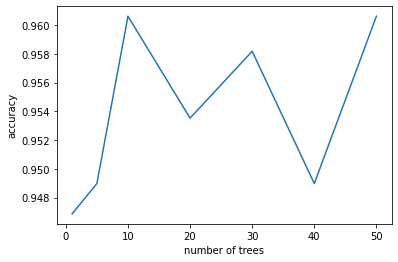

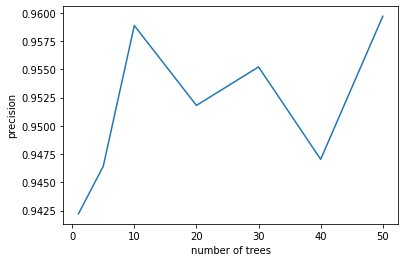

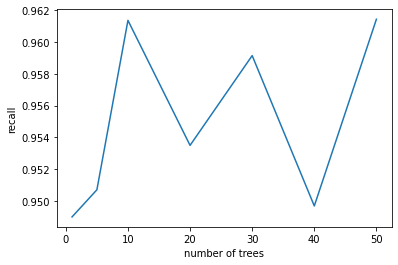

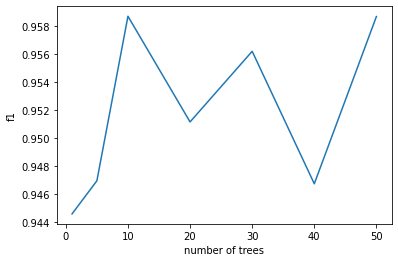

In [38]:
# plot accuracy 
plt.plot(ntree_itr, [r[0] for r in reports_house], label="accuracy")
plt.xlabel("number of trees")
plt.ylabel("accuracy")
plt.show()
# plot precision 
plt.plot(ntree_itr, [r[1] for r in reports_house], label="precision")
plt.xlabel("number of trees")
plt.ylabel("precision")
plt.show()
# plot recall 
plt.plot(ntree_itr, [r[2] for r in reports_house], label="recall")
plt.xlabel("number of trees")
plt.ylabel("recall")
plt.show()
# plot f1
plt.plot(ntree_itr, [r[3] for r in reports_house], label="f1")
plt.xlabel("number of trees")
plt.ylabel("f1")
plt.show()

### Discussion

I would choose ntree=10, since it maximize all evaluation metrics.  
For this dataset, accuracy, precision, recall, and f1 are almost equally sensitive to the change of n.  
Beyond n>10, adding more trees does not increase the performance.  


## Extra Credit 1, Gini

### wine data

In [39]:
# wine, gini
reports_wine_gini = []
print("accuracy, precision, recall, f1")
for cur_n in ntree_itr:
    report = dispatch_k_fold(wine_data, 
        wine_attribute, 
        wine_attribute_type, 
        wine_attribute_options, 
        wine_tag_col, 
        minimal_size_for_split=0.,
        minimal_gain=0.,
        maximal_depth=10000,
        algo="gini",  
        random_state=42, 
        k_fold=10,
        n_trees=cur_n,
        binary_class=False, 
        bootstrap_percentage=0.9
    )
    reports_wine_gini.append(report)
    print("n =", cur_n, report)

accuracy, precision, recall, f1
n = 1 [0.83136395 0.83953704 0.8402381  0.83054675]
n = 5 [0.97211257 0.975      0.97519841 0.97383644]
n = 10 [0.95522876 0.96349206 0.95539683 0.95497928]
n = 20 [0.95519436 0.96357143 0.95571429 0.95490596]
n = 30 [0.96663227 0.96912698 0.97043651 0.96725201]
n = 40 [0.96136911 0.96436508 0.96785714 0.96233581]
n = 50 [0.97222222 0.9765873  0.97349206 0.97297073]


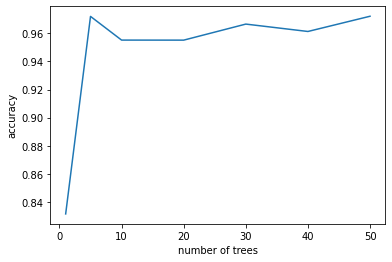

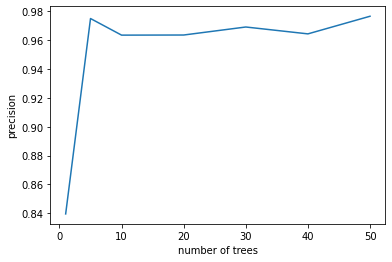

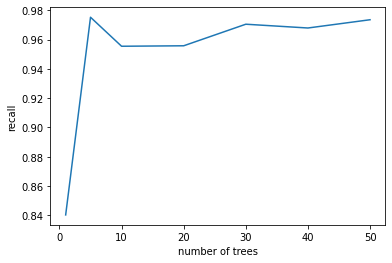

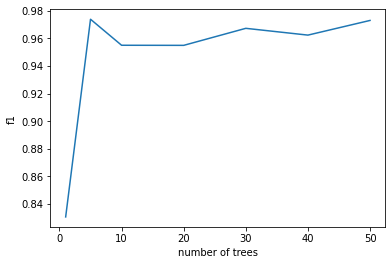

In [40]:
# plot accuracy 
plt.plot(ntree_itr, [r[0] for r in reports_wine_gini], label="accuracy")
plt.xlabel("number of trees")
plt.ylabel("accuracy")
plt.show()
# plot precision 
plt.plot(ntree_itr, [r[1] for r in reports_wine_gini], label="precision")
plt.xlabel("number of trees")
plt.ylabel("precision")
plt.show()
# plot recall 
plt.plot(ntree_itr, [r[2] for r in reports_wine_gini], label="recall")
plt.xlabel("number of trees")
plt.ylabel("recall")
plt.show()
# plot f1
plt.plot(ntree_itr, [r[3] for r in reports_wine_gini], label="f1")
plt.xlabel("number of trees")
plt.ylabel("f1")
plt.show()

### Discussion

I would choose ntree=5, since it maximize all evaluation metrics.  
Beyond n>5, adding more trees does not increase the performance.  
For this dataset, accuracy, precision, recall, and f1 are almost equally sensitive to the change of n.  
Compare to the same dataset using the entropy algorithm, the gini criteria perform better at a lower ntree.


### house data

In [41]:
reports_house_gini = []
print("accuracy, precision, recall, f1")
for cur_n in ntree_itr:
    report = dispatch_k_fold(house_data, 
        house_attribute, 
        house_attribute_type, 
        house_attribute_options, 
        house_tag_col, 
        minimal_size_for_split=0.,
        minimal_gain=0.,
        maximal_depth=10000,
        algo="gini",  
        random_state=42, 
        k_fold=10,
        n_trees=10,
        binary_class=False, 
        bootstrap_percentage=0.9
    )
    reports_house_gini.append(report)
    print("n =", cur_n, report)

accuracy, precision, recall, f1
n = 1 [0.9581194  0.95659145 0.95697325 0.95596741]
n = 5 [0.94426659 0.9448647  0.94016047 0.94125417]
n = 10 [0.93512534 0.93472947 0.93286566 0.93205097]
n = 20 [0.96044498 0.95994381 0.9623895  0.95885259]
n = 30 [0.94670039 0.94697614 0.94666604 0.94427075]
n = 40 [0.9533575  0.95068854 0.9530145  0.95118044]
n = 50 [0.95573845 0.95428876 0.95625209 0.95395187]


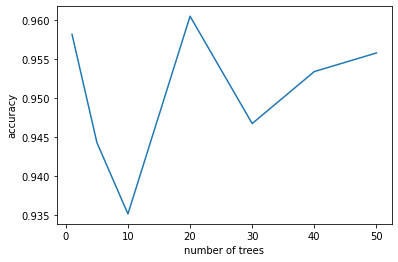

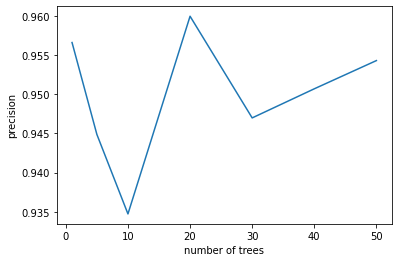

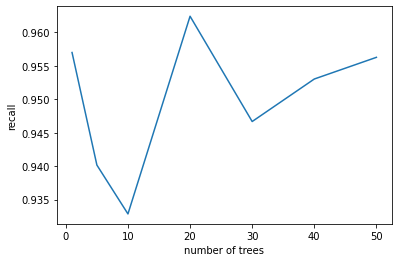

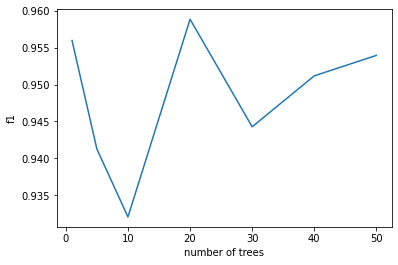

In [42]:
# plot accuracy 
plt.plot(ntree_itr, [r[0] for r in reports_house_gini], label="accuracy")
plt.xlabel("number of trees")
plt.ylabel("accuracy")
plt.show()
# plot precision 
plt.plot(ntree_itr, [r[1] for r in reports_house_gini], label="precision")
plt.xlabel("number of trees")
plt.ylabel("precision")
plt.show()
# plot recall 
plt.plot(ntree_itr, [r[2] for r in reports_house_gini], label="recall")
plt.xlabel("number of trees")
plt.ylabel("recall")
plt.show()
# plot f1
plt.plot(ntree_itr, [r[3] for r in reports_house_gini], label="f1")
plt.xlabel("number of trees")
plt.ylabel("f1")
plt.show()

### Discussion

I would choose ntree=20, since it maximize all evaluation metrics.  
Beyond n>20, adding more trees does not increase the performance.  
For this dataset, accuracy, precision, recall, and f1 are almost equally sensitive to the change of n.  
Compare to the same dataset using the entropy algorithm, the gini criteria is worse since it reached its peak performance at a higher ntree. 


##  Extra Credit 2, Cancer

In [43]:
cancer_data, cancer_attribute = load_data("datasets/hw3_cancer.csv", csv_delimiter='\t')
cancer_attribute_type = ["numerical","numerical","numerical","numerical","numerical","numerical","numerical","numerical","numerical","class"]
cancer_attribute_options = get_possible_options(cancer_data, cancer_attribute, cancer_attribute_type)
cancer_tag_col = -1
print("classes: " , cancer_attribute_options[cancer_tag_col])

classes:  [0.0, 1.0]


In [44]:
reports_cancer = []
print("accuracy, precision, recall, f1")
for cur_n in ntree_itr:
    report = dispatch_k_fold(cancer_data, 
        cancer_attribute, 
        cancer_attribute_type, 
        cancer_attribute_options, 
        cancer_tag_col, 
        minimal_size_for_split=0.,
        minimal_gain=0.,
        maximal_depth=10000,
        algo="entropy",  
        random_state=42, 
        k_fold=10,
        n_trees=10,
        binary_class=False, 
        bootstrap_percentage=0.9
    )
    reports_cancer.append(report)
    print("n =", cur_n, report)

accuracy, precision, recall, f1
n = 1 [0.95724229 0.95361118 0.95366787 0.95276466]
n = 5 [0.96001779 0.95667507 0.95681401 0.95608403]
n = 10 [0.96287493 0.95969382 0.95990097 0.9592253 ]
n = 20 [0.96293646 0.95705292 0.96297343 0.95947437]
n = 30 [0.95579302 0.95185185 0.95266425 0.95153446]
n = 40 [0.952956   0.95080745 0.94664734 0.94747531]
n = 50 [0.96009944 0.95516766 0.95883092 0.95642063]


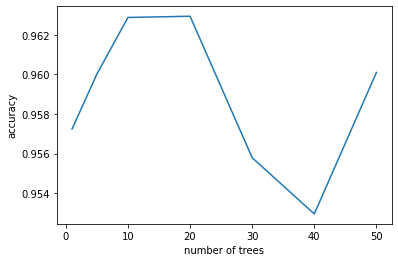

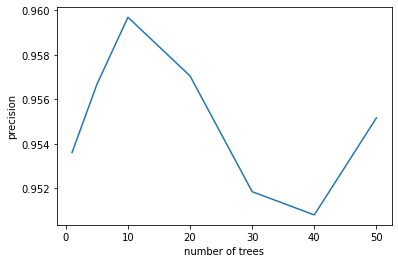

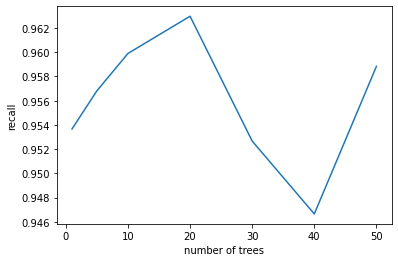

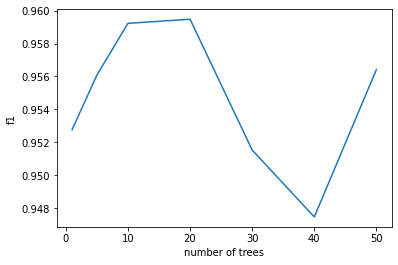

In [45]:
# plot accuracy 
plt.plot(ntree_itr, [r[0] for r in reports_cancer], label="accuracy")
plt.xlabel("number of trees")
plt.ylabel("accuracy")
plt.show()
# plot precision 
plt.plot(ntree_itr, [r[1] for r in reports_cancer], label="precision")
plt.xlabel("number of trees")
plt.ylabel("precision")
plt.show()
# plot recall 
plt.plot(ntree_itr, [r[2] for r in reports_cancer], label="recall")
plt.xlabel("number of trees")
plt.ylabel("recall")
plt.show()
# plot f1
plt.plot(ntree_itr, [r[3] for r in reports_cancer], label="f1")
plt.xlabel("number of trees")
plt.ylabel("f1")
plt.show()

### Discussion

I would choose ntree=10, since after this point, the precision drop greatly.  
For this dataset, I think precision and recall are more sensitive to the change of n. Recall is harder to optimize since it require a higher ntree to reach its performance peak. And precision is easier to optimize since it reaches the peak at a lower ntree.


##  Extra Credit 3, Contraceptive Method Choice Dataset

In [46]:
cmc_data, cmc_attribute = load_data("datasets/cmc.data", csv_delimiter=',')
cmc_attribute_type = ["numerical","categorical","categorical","numerical","categorical","categorical","categorical","categorical","categorical","class"]
cmc_attribute_options = get_possible_options(cmc_data, cmc_attribute, cmc_attribute_type)
cmc_tag_col = -1

In [49]:
reports_cmc = []
print("accuracy, precision, recall, f1")
for cur_n in ntree_itr:
    report = dispatch_k_fold(cmc_data, 
        cmc_attribute, 
        cmc_attribute_type, 
        cmc_attribute_options, 
        cmc_tag_col, 
        minimal_size_for_split=0.,
        minimal_gain=0.,
        maximal_depth=10000,
        algo="entropy",  
        random_state=42, 
        k_fold=10,
        n_trees=10,
        binary_class=False, 
        bootstrap_percentage=0.9
    )
    reports_cmc.append(report)
    print("n =", cur_n, report)

accuracy, precision, recall, f1
n = 1 [0.50308411 0.48532134 0.47929222 0.47925435]
n = 5 [0.5063941  0.49302259 0.48544404 0.48681859]
n = 10 [0.50376438 0.48684672 0.48326039 0.48152954]
n = 20 [0.52135978 0.51266334 0.49793273 0.5000513 ]
n = 30 [0.50234427 0.48406483 0.48086322 0.47996531]
n = 40 [0.50581949 0.49211695 0.4848594  0.4854291 ]
n = 50 [0.52205856 0.50541257 0.49784597 0.49784588]


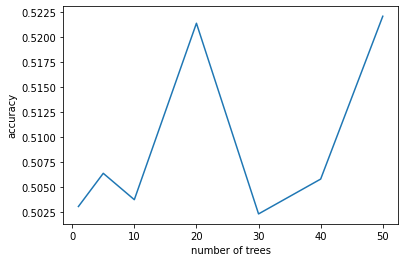

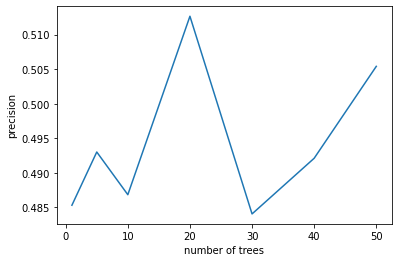

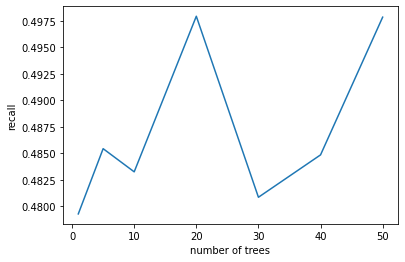

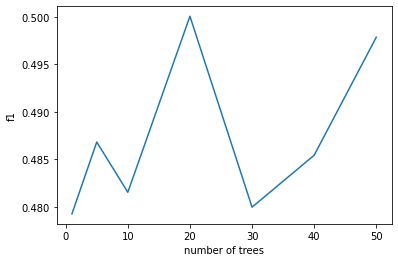

In [50]:
# plot accuracy 
plt.plot(ntree_itr, [r[0] for r in reports_cmc], label="accuracy")
plt.xlabel("number of trees")
plt.ylabel("accuracy")
plt.show()
# plot precision 
plt.plot(ntree_itr, [r[1] for r in reports_cmc], label="precision")
plt.xlabel("number of trees")
plt.ylabel("precision")
plt.show()
# plot recall 
plt.plot(ntree_itr, [r[2] for r in reports_cmc], label="recall")
plt.xlabel("number of trees")
plt.ylabel("recall")
plt.show()
# plot f1
plt.plot(ntree_itr, [r[3] for r in reports_cmc], label="f1")
plt.xlabel("number of trees")
plt.ylabel("f1")
plt.show()

### Discussion

I would choose ntree=20, the performance is almost the same at ntree=50, but not better and it would require a longer training.
For this dataset, accuracy, precision, recall, and f1 are almost equally sensitive to the change of n.  
